# 01. Data Exploration

## Objective
Load the NYC Airbnb dataset using **NumPy exclusively** (assisted by Python's `csv` module for parsing) and perform Exploratory Data Analysis (EDA) to understand the data distribution and relationships.

## 1. Data Loading
We will load the `AB_NYC_2019.csv` file. Since the file contains mixed types and quoted strings with commas, `np.genfromtxt` can be complex to configure directly. We will use Python's built-in `csv` module to parse the rows and then convert them to a structured NumPy array.

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure plots display in the notebook
%matplotlib inline

In [2]:
DATA_PATH = '../data/raw/AB_NYC_2019.csv'

def load_data(file_path):
    with open(file_path, mode='r', encoding='utf-8') as f:
        reader = csv.reader(f)
        header = next(reader)
        data = list(reader)
    
    # Convert to NumPy array of objects to handle mixed types temporarily
    # We will refine types for specific columns later during analysis
    data_np = np.array(data, dtype=object)
    return header, data_np

# Load the data
header, data = load_data(DATA_PATH)

## 2. Data Overview
Displaying the first 5 rows, column names, and data shape.

In [3]:
print("Feature Names (Columns):\n", header)
print("\nData Shape:", data.shape)
print("\nFirst 5 Rows:")
print(data[:5])

Feature Names (Columns):
 ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

Data Shape: (48895, 16)

First 5 Rows:
[['2539' 'Clean & quiet apt home by the park' '2787' 'John' 'Brooklyn'
  'Kensington' '40.64749' '-73.97237' 'Private room' '149' '1' '9'
  '2018-10-19' '0.21' '6' '365']
 ['2595' 'Skylit Midtown Castle' '2845' 'Jennifer' 'Manhattan' 'Midtown'
  '40.75362' '-73.98377' 'Entire home/apt' '225' '1' '45' '2019-05-21'
  '0.38' '2' '355']
 ['3647' 'THE VILLAGE OF HARLEM....NEW YORK !' '4632' 'Elisabeth'
  'Manhattan' 'Harlem' '40.80902' '-73.9419' 'Private room' '150' '3' '0'
  '' '' '1' '365']
 ['3831' 'Cozy Entire Floor of Brownstone' '4869' 'LisaRoxanne'
  'Brooklyn' 'Clinton Hill' '40.68514' '-73.95976' 'Entire home/apt' '89'
  '1' '270' '2019-07-05' '4.64' '1' '194']
 ['5

Type

In [4]:
header = data[0]
data = data[1:]
for e in data[1]:
    print("Type of ", type(e))
    print("Value ", e)

Type of  <class 'str'>
Value  3647
Type of  <class 'str'>
Value  THE VILLAGE OF HARLEM....NEW YORK !
Type of  <class 'str'>
Value  4632
Type of  <class 'str'>
Value  Elisabeth
Type of  <class 'str'>
Value  Manhattan
Type of  <class 'str'>
Value  Harlem
Type of  <class 'str'>
Value  40.80902
Type of  <class 'str'>
Value  -73.9419
Type of  <class 'str'>
Value  Private room
Type of  <class 'str'>
Value  150
Type of  <class 'str'>
Value  3
Type of  <class 'str'>
Value  0
Type of  <class 'str'>
Value  
Type of  <class 'str'>
Value  
Type of  <class 'str'>
Value  1
Type of  <class 'str'>
Value  365


Convert datatype

In [5]:
# Define the specific data type for each field
# Using native types (int64, float64, datetime) enables vectorization
dtype = np.dtype([
    ('id', np.int64),
    ('name', 'U100'),
    ('host_id', np.int64),
    ('host_name', 'U50'),
    ('neighbourhood_group', 'U50'),
    ('neighbourhood', 'U50'),
    ('latitude', np.float64),
    ('longitude', np.float64),
    ('room_type', 'U20'),
    ('price', np.int32),
    ('minimum_nights', np.int32),
    ('number_of_reviews', np.int32),
    ('last_review', 'M8[D]'),           # NumPy datetime format
    ('reviews_per_month', np.float64),
    ('calculated_host_listings_count', np.int32),
    ('availability_365', np.int32)
])

# Helpers for vectorized cleaning of empty strings
def clean_int(arr):
    # Replace empty strings with 0 before converting
    return np.where(arr == '', '0', arr).astype(np.int32)

def clean_float(arr):
    # Replace empty strings with nan before converting
    return np.where(arr == '', 'nan', arr).astype(np.float64)

def clean_date(arr):
    # Replace empty strings with NaT (Not a Time) before converting
    return np.where(arr == '', 'NaT', arr).astype('M8[D]')

# Create a new empty structured array
N = len(data)
structured_data = np.zeros(N, dtype=dtype)

# Assign columns using vectorized conversion
# data[:, i] extracts the column from the raw string array
structured_data['id'] = data[:, 0].astype(np.int64)
structured_data['name'] = data[:, 1]
structured_data['host_id'] = data[:, 2].astype(np.int64)
structured_data['host_name'] = data[:, 3]
structured_data['neighbourhood_group'] = data[:, 4]
structured_data['neighbourhood'] = data[:, 5]
structured_data['latitude'] = clean_float(data[:, 6])
structured_data['longitude'] = clean_float(data[:, 7])
structured_data['room_type'] = data[:, 8]
structured_data['price'] = clean_int(data[:, 9])
structured_data['minimum_nights'] = clean_int(data[:, 10])
structured_data['number_of_reviews'] = clean_int(data[:, 11])
structured_data['last_review'] = clean_date(data[:, 12])
structured_data['reviews_per_month'] = clean_float(data[:, 13])
structured_data['calculated_host_listings_count'] = clean_int(data[:, 14])
structured_data['availability_365'] = clean_int(data[:, 15])

data = structured_data
print("New Data Shape:", data.shape)
print("Dtype Names:", data.dtype.names)
print("\nFirst 3 rows (structured):")
print(data[:3])

New Data Shape: (48894,)
Dtype Names: ('id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365')

First 3 rows (structured):
[(2595, 'Skylit Midtown Castle', 2845, 'Jennifer', 'Manhattan', 'Midtown', 40.75362, -73.98377, 'Entire home/apt', 225, 1,  45, '2019-05-21', 0.38, 2, 355)
 (3647, 'THE VILLAGE OF HARLEM....NEW YORK !', 4632, 'Elisabeth', 'Manhattan', 'Harlem', 40.80902, -73.9419 , 'Private room', 150, 3,   0,        'NaT',  nan, 1, 365)
 (3831, 'Cozy Entire Floor of Brownstone', 4869, 'LisaRoxanne', 'Brooklyn', 'Clinton Hill', 40.68514, -73.95976, 'Entire home/apt',  89, 1, 270, '2019-07-05', 4.64, 1, 194)]


In [6]:
header = data[0]
for e in data[1]:
    print("Type of ", type(e))
    print("Value ", e)

Type of  <class 'numpy.int64'>
Value  3647
Type of  <class 'numpy.str_'>
Value  THE VILLAGE OF HARLEM....NEW YORK !
Type of  <class 'numpy.int64'>
Value  4632
Type of  <class 'numpy.str_'>
Value  Elisabeth
Type of  <class 'numpy.str_'>
Value  Manhattan
Type of  <class 'numpy.str_'>
Value  Harlem
Type of  <class 'numpy.float64'>
Value  40.80902
Type of  <class 'numpy.float64'>
Value  -73.9419
Type of  <class 'numpy.str_'>
Value  Private room
Type of  <class 'numpy.int32'>
Value  150
Type of  <class 'numpy.int32'>
Value  3
Type of  <class 'numpy.int32'>
Value  0
Type of  <class 'numpy.datetime64'>
Value  NaT
Type of  <class 'numpy.float64'>
Value  nan
Type of  <class 'numpy.int32'>
Value  1
Type of  <class 'numpy.int32'>
Value  365


## 3. Exploratory Data Analysis (EDA)

### 3.1. Price Distribution by Borough
**Question**: What is the average listing price across the 5 main boroughs (`neighbourhood_group`)?

Average Price by Borough:
Bronx: $87.50
Brooklyn: $124.38
Manhattan: $196.88
Queens: $99.52
Staten Island: $114.81


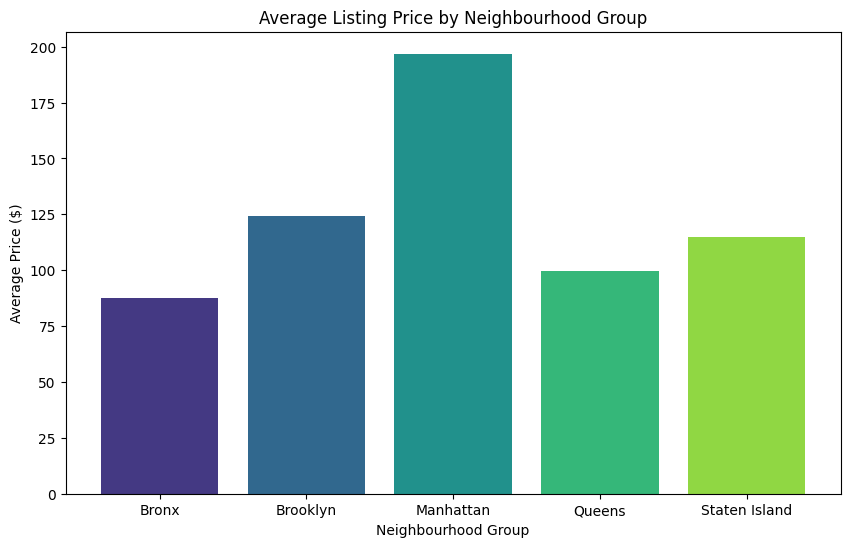

In [7]:
# Access data directly by field name (Cleaner and Faster!)
neighbourhood_groups = data['neighbourhood_group']
prices = data['price']  # This is already valid int32 data

# 1. Grouping
unique_boroughs, borough_indices = np.unique(neighbourhood_groups, return_inverse=True)

# 2. Aggregation (Sum and Count)
price_sums = np.bincount(borough_indices, weights=prices)
counts = np.bincount(borough_indices)

# 3. Mean Calculation
mean_prices = price_sums / counts
# -----------------------------

print("Average Price by Borough:")
for borough, price in zip(unique_boroughs, mean_prices):
    print(f"{borough}: ${price:.2f}")

# Visualization
plt.figure(figsize=(10, 6))
colors = sns.color_palette('viridis', len(unique_boroughs))
plt.bar(unique_boroughs, mean_prices, color=colors)
plt.title('Average Listing Price by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Price ($)')
plt.show()

### 3.2. Room Type Market Share
**Question**: What is the proportion of each `room_type`?

Room Type Distribution:
Entire home/apt: 25409 (51.97%)
Private room: 22325 (45.66%)
Shared room: 1160 (2.37%)


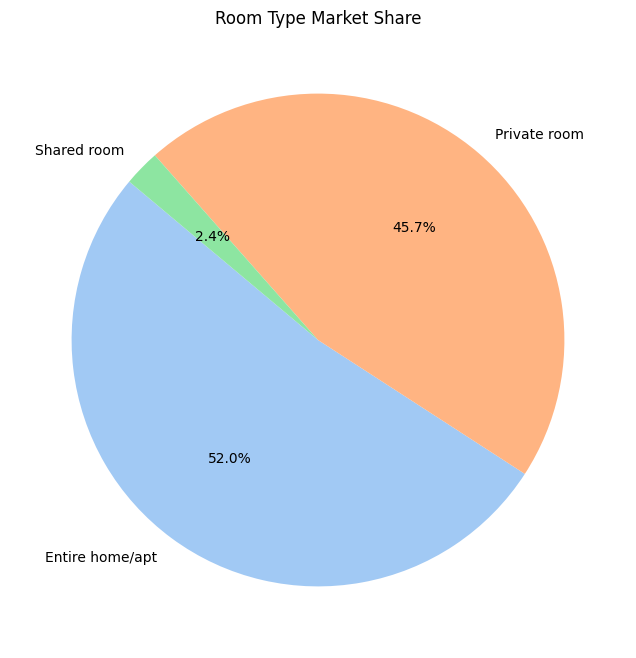

In [8]:
room_types = data['room_type']

# Calculate counts
unique_room_types, counts = np.unique(room_types, return_counts=True)

# Calculate percentages
total_listings = len(room_types)
percentages = (counts / total_listings) * 100

print("Room Type Distribution:")
for rt, count, pct in zip(unique_room_types, counts, percentages):
    print(f"{rt}: {count} ({pct:.2f}%)")

# Visualization: Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique_room_types, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Room Type Market Share')
plt.show()

### 3.3. Activity vs. Price
**Question**: Is there a correlation between `price` and the listing's popularity (`number_of_reviews`)?

Correlation between Price and Number of Reviews: -0.0480


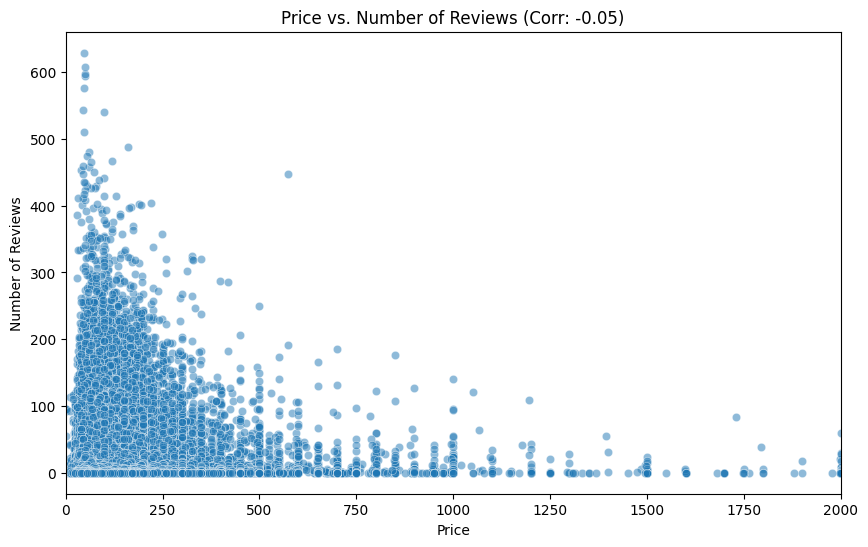

In [9]:
num_reviews_str = data['number_of_reviews']
num_reviews = num_reviews_str.astype(float)

# Calculate Correlation
correlation = np.corrcoef(prices, num_reviews)[0, 1]
print(f"Correlation between Price and Number of Reviews: {correlation:.4f}")

# Visualization: Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=prices, y=num_reviews, alpha=0.5)
plt.title(f'Price vs. Number of Reviews (Corr: {correlation:.2f})')
plt.xlabel('Price')
plt.ylabel('Number of Reviews')
plt.xlim(0, 2000) # Limiting x-axis to see the dense part better
plt.show()

### 3.4. Busiest Hosts
**Question**: Identify the **Top 10 Host IDs** by the number of active listings (`calculated_host_listings_count`).

Top 10 Busiest Hosts:
Host ID: 219517861, Listings: 327
Host ID: 107434423, Listings: 232
Host ID: 30283594, Listings: 121
Host ID: 137358866, Listings: 103
Host ID: 16098958, Listings: 96
Host ID: 12243051, Listings: 96
Host ID: 61391963, Listings: 91
Host ID: 22541573, Listings: 87
Host ID: 200380610, Listings: 65
Host ID: 7503643, Listings: 52


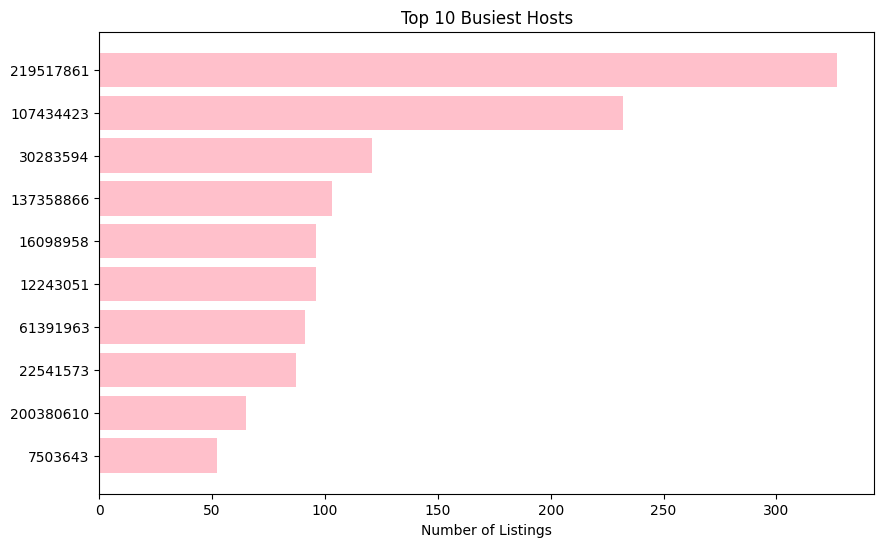

In [10]:
host_ids = data['host_id']
host_counts_str = data['calculated_host_listings_count']
host_counts = host_counts_str.astype(int)

# We want to count listings per host. 
# Note: The 'calculated_host_listings_count' column is already pre-calculated in the dataset for each row.
# However, to be thorough, we can count the occurrences of each host_id via np.unique, 
# or if we trust the column, we can just find the hosts with the max value.
# Let's count them manually to be safe and verify.
unique_hosts, real_counts = np.unique(host_ids, return_counts=True)

# Sort by real_counts descending
sorted_params = np.argsort(real_counts)[::-1]
top_10_indices = sorted_params[:10]

top_10_hosts = unique_hosts[top_10_indices]
top_10_counts = real_counts[top_10_indices]

print("Top 10 Busiest Hosts:")
for host, count in zip(top_10_hosts, top_10_counts):
    print(f"Host ID: {host}, Listings: {count}")

# Visualization: Horizontal Bar Chart
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(top_10_hosts))
plt.barh(y_pos, top_10_counts, align='center', color='pink')
plt.yticks(y_pos, top_10_hosts)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.xlabel('Number of Listings')
plt.title('Top 10 Busiest Hosts')
plt.show()

### 3.5 Find out more about neiberhoods presented 

In [11]:
nei_list = ['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']
stats_list = ['min', '25%', '50%', '75%', 'max']
PERCENTILES = [0, 25, 50, 75, 100] 

stat_array = np.empty((len(nei_list), len(stats_list)))

for i, borough in enumerate(nei_list):
    mask = (neighbourhood_groups == borough)
    borough_prices = prices[mask]
    
    if borough_prices.size > 0:

        stats = np.percentile(borough_prices, PERCENTILES)
        stat_array[i] = stats
    else:
        stat_array[i] = np.full(len(stats_list), np.nan)

print("{:<15} {:<8} {:<8} {:<8} {:<8} {:<8}".format("Borough", *stats_list))
print("-" * 55)
for i, borough in enumerate(nei_list):
    print("{:<15} {:<8.2f} {:<8.2f} {:<8.2f} {:<8.2f} {:<8.2f}".format(
        borough, *stat_array[i]
    ))


Borough         min      25%      50%      75%      max     
-------------------------------------------------------
Brooklyn        0.00     60.00    90.00    150.00   10000.00
Manhattan       0.00     95.00    150.00   220.00   10000.00
Queens          10.00    50.00    75.00    110.00   10000.00
Staten Island   13.00    50.00    75.00    110.00   5000.00 
Bronx           0.00     45.00    65.00    99.00    2500.00 


We can see from our statistical table that we have some extreme values, therefore we need to remove them for the sake of a better visualization


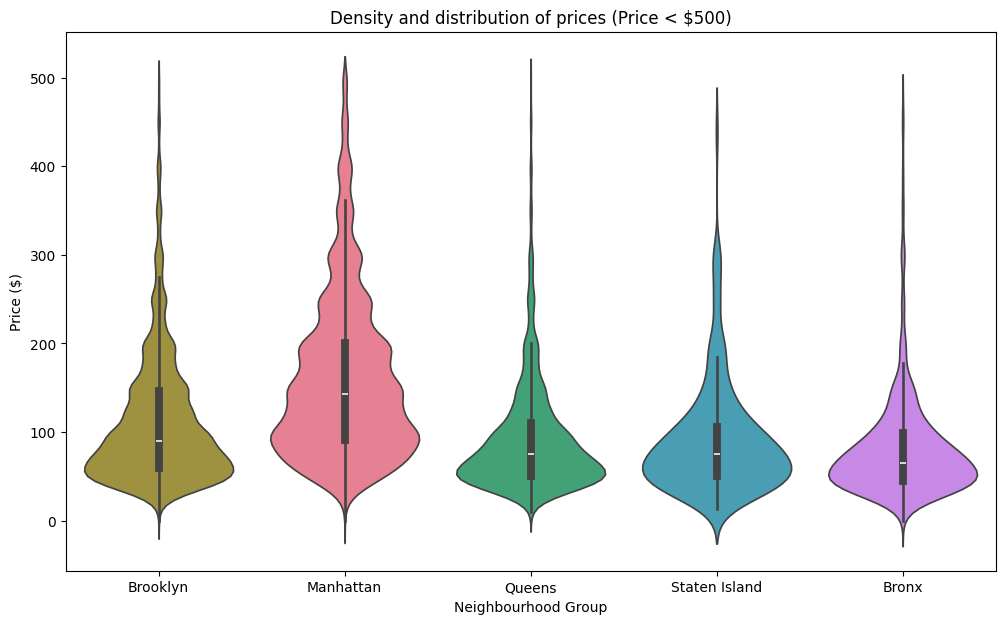

In [34]:
mask = data['price'] < 500
nei_gr_filtered = data['neighbourhood_group'][mask]
price_filtered = data['price'][mask]

plt.figure(figsize=(12, 7))
viz_2 = sns.violinplot(
    x=nei_gr_filtered, 
    y=price_filtered, 
    order=nei_list,
    palette='husl',
    hue=nei_gr_filtered
)
viz_2.set_title(f'Density and distribution of prices (Price < $500)')
viz_2.set_xlabel('Neighbourhood Group')
viz_2.set_ylabel('Price ($)')
plt.show()


The statistical table and violin plot clearly reveal the expected pricing hierarchy among NYC boroughs:

- Manhattan holds the highest average price (around $150) and exhibits the widest distribution of listing prices.

- Brooklyn follows, maintaining the second-highest average (around $90).

- Queens and Staten Island demonstrate the most similar and stable price distributions.

- The Bronx consistently offers the cheapest average rate among the five boroughs.

This density and price order are consistent with the boroughs' established cost of living, where Manhattan is known globally as a premium location, driving its listings to the top of the price range.

Top 10 Neighbourhoods:
Williamsburg: 3920
Bedford-Stuyvesant: 3714
Harlem: 2658
Bushwick: 2465
Upper West Side: 1971
Hell's Kitchen: 1958
East Village: 1853
Upper East Side: 1798
Crown Heights: 1564
Midtown: 1545


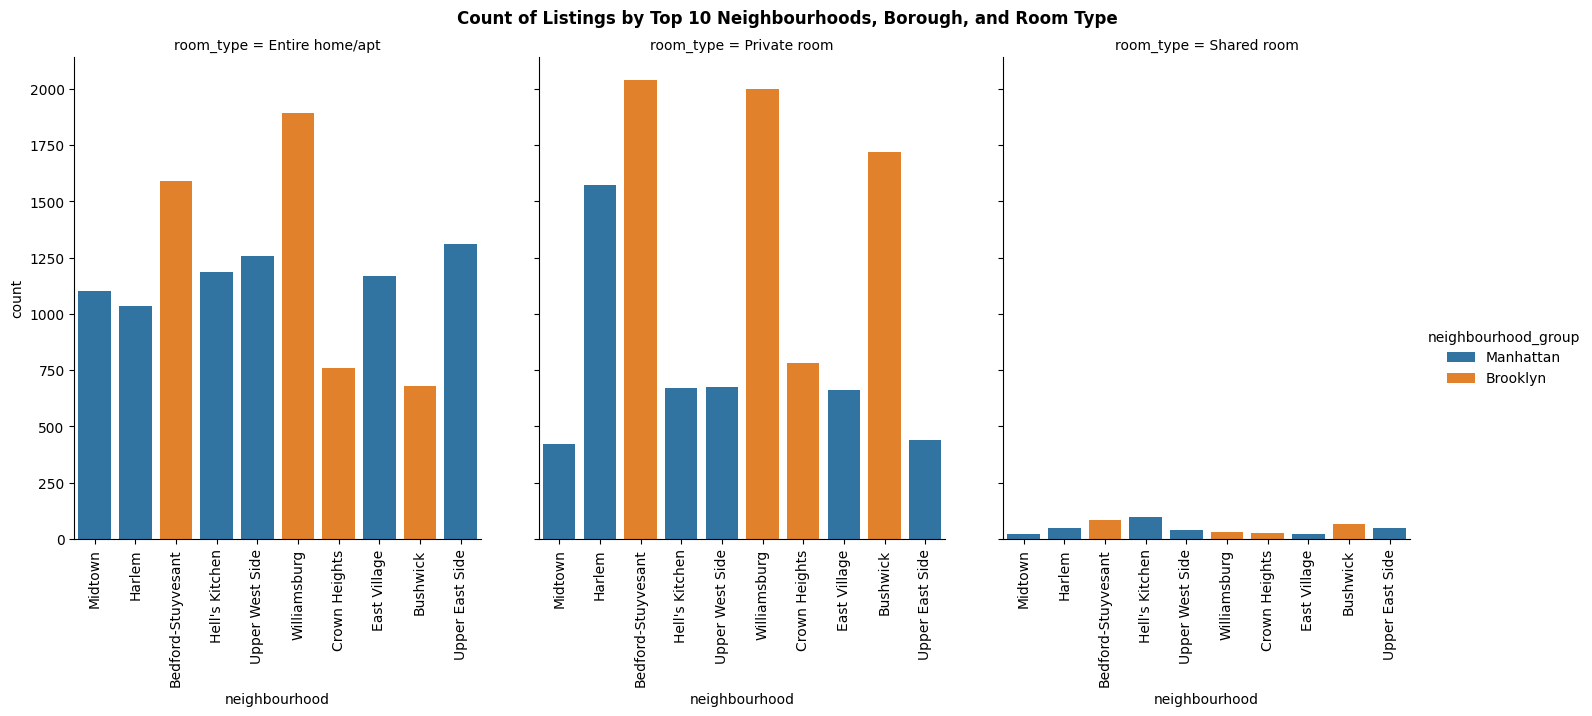

In [13]:
neighbourhood = data['neighbourhood']
neighbourhood_groups = data['neighbourhood_group']
room_type = data['room_type']

unique_neigh, counts = np.unique(neighbourhood, return_counts=True)

sorted_indices = np.argsort(counts)[::-1]

top_10_neighbourhoods = unique_neigh[sorted_indices][:10]

print("Top 10 Neighbourhoods:")
for i, n in enumerate(top_10_neighbourhoods):
    print(f"{n}: {counts[sorted_indices][i]}")

mask_top_10 = np.zeros(neighbourhood.shape, dtype=bool)

for n in top_10_neighbourhoods:
    mask_top_10 = mask_top_10 | (data['neighbourhood'] == n)

sub_neighbourhood = neighbourhood[mask_top_10]
sub_neighbourhood_group = neighbourhood_groups[mask_top_10]
sub_room_type = room_type[mask_top_10]

viz_data = {
    'neighbourhood': sub_neighbourhood,
    'neighbourhood_group': sub_neighbourhood_group,
    'room_type': sub_room_type
}

viz_3 = sns.catplot(
    data=viz_data, 
    x='neighbourhood', 
    hue='neighbourhood_group', 
    col='room_type', 
    kind='count',
    height=6, 
    aspect=0.8
)
viz_3.set_xticklabels(rotation=90)
plt.subplots_adjust(top=0.9)
viz_3.fig.suptitle('Count of Listings by Top 10 Neighbourhoods, Borough, and Room Type', weight='bold')
plt.show()


1.  **Shared Room Scarcity**: The most striking observation is that the number of **"Shared room"** type Airbnb listings is **negligible** or **almost entirely absent** within these 10 most listing-populated neighborhoods.
2.  **Borough Dominance**: The top 10 busiest neighborhoods are represented exclusively by just two boroughs: **Manhattan** and **Brooklyn**. This strongly validates the assumption that these are the two primary destinations for short-term rentals in NYC.
3.  **Leading Neighbourhoods**:
    * In **Brooklyn**, **Williamsburg** and **Bedford-Stuyvesant** show the highest counts across the relevant room types.
    * In **Manhattan**, **Harlem** stands out as having a significant number of listings among the top group.

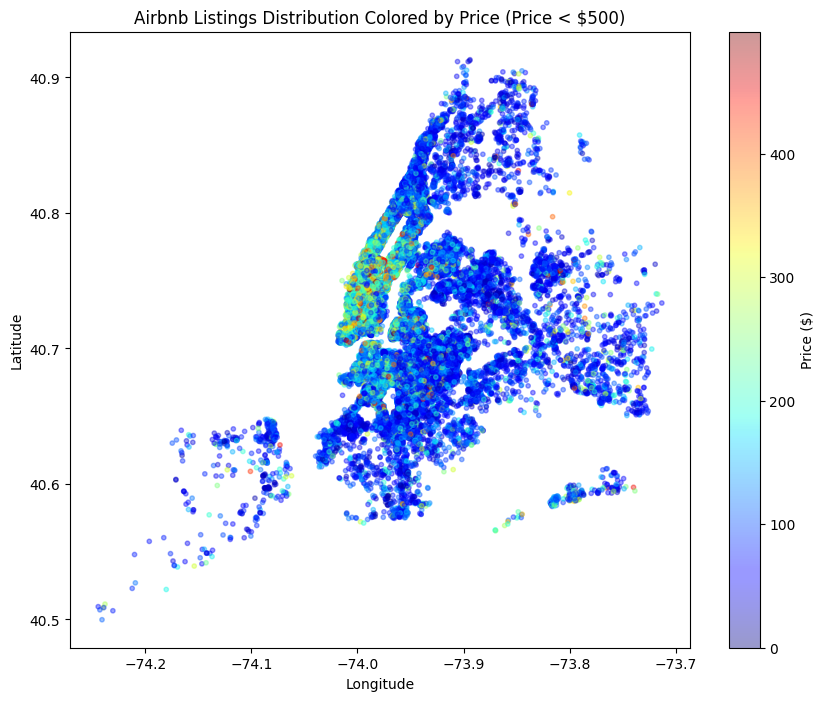

In [23]:
mask_no_extreme = (prices < 500) 

longitude_filtered = data['longitude'][mask_no_extreme]
latitude_filtered = data['latitude'][mask_no_extreme]
price_filtered = data['price'][mask_no_extreme]

plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    x=longitude_filtered, 
    y=latitude_filtered, 
    c=price_filtered,  
    cmap=plt.get_cmap('jet'), 
    s=10, 
    alpha=0.4
)

plt.title('Airbnb Listings Distribution Colored by Price (Price < ${})'.format(PRICE_THRESHOLD))
plt.xlabel('Longitude')
plt.ylabel('Latitude')

cbar = plt.colorbar(scatter)
cbar.set_label('Price ($)')

plt.show()

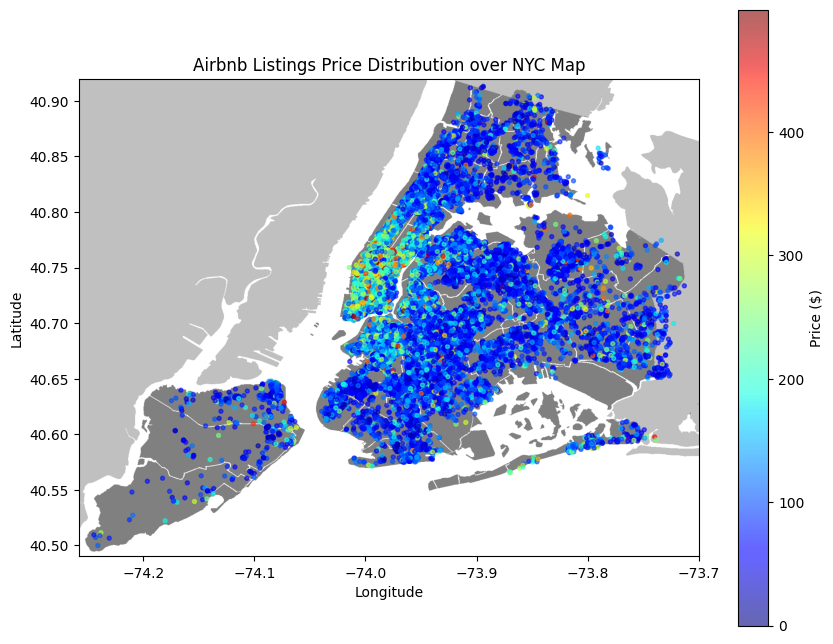

In [ ]:
nyc_img = plt.imread('../data/raw/nyc_map.png')

plt.figure(figsize=(10, 8))

plt.imshow(nyc_img, zorder=0, extent=[-74.258, -73.7, 40.49,40.92], aspect='equal')

scatter = plt.scatter(
    x=longitude_filtered, 
    y=latitude_filtered, 
    c=price_filtered, 
    cmap=plt.get_cmap('jet'), 
    s=8,
    alpha=0.6, 
    zorder=1 
)


plt.title('Airbnb Listings Price Distribution over NYC Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

cbar = plt.colorbar(scatter)
cbar.set_label('Price ($)')
